# Latency Arbitrage
## Two Market Model

TODO:
   7. add a second market
   8. add routing
   9. update SIP
   10. (At time time, a system w/o LA is complete)
   11. plot
   12. add LA
   13. add other measures

In [1]:
%matplotlib inline
import numpy as np
import bisect
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

import warnings

warnings.simplefilter("error")

## Classes and functions

In [2]:
class Order:
    def __init__(self, price, valuation, time, market):
        self.p = price
        self.pv = valuation
        self.t = time
        self.m = market
        
    def __getitem__(self, i):
        if i is 0:
            return self.p
        elif i is 1:
            return self.pv
        elif i is 2:
            return self.t
        elif i is 3:
            return self.m
        else:
            raise IndexError("{} is not a valid index.\n Use 0 for price, 1 for valuation, 2 for time".format(i))

In [3]:
class KeyWrapper:
    def __init__(self, iterable, key):
        self.it = iterable
        self.key = key

    def __getitem__(self, i):
        return self.key(self.it[i])

    def __len__(self):
        return len(self.it)

In [4]:
def surplus(ask,bid,t):
    # ask/bid order: [price,valuation,time placed]
    p = ask.p # assmue ask is the incumbent order
    if t is ask.t: # unless bid is...
        p = bid.p
    return  np.exp(-rho*(t-bid.t))*(bid.pv-p) + \
            np.exp(-rho*(t-ask.t))*(p-ask.pv)

In [5]:
def clearing(M,m,t,sip,delta,surpluses,execution_times,n_executions):
    # Clear if ask < bid
    if (M[m].ask_q[0].p <= M[m].bid_q[-1].p):
        # clear the 2 orders
        ask = M[m].ask_q.popleft()
        bid = M[m].bid_q.pop()
        # Metrics related to order clearning
        #     calculate the surplus
        surpluses.append(surplus(ask,bid,t))
        #     calculate the execution time (for one of them it's just 0)
        execution_times.append(abs(ask.t-bid.t))
        #     increment # order executed by two
        n_executions[0] += 2
        #     free up the two traders (we don't do this :\)
        #n_orders -=2
        
        # send new market status to SIP
        sip.send(t,delta,m,M[m].ask_q[0],M[m].bid_q[-1])
        
        
        #######################Tracing
        A_entry=[t,ask.p]
        idx = bisect.bisect(KeyWrapper(Ask_t, key=lambda c: c[0]), A_entry[0])
        Ask_t.insert(idx, A_entry)
        B_entry=[t,bid.p]
        idx = bisect.bisect(KeyWrapper(Bid_t, key=lambda c: c[0]), B_entry[0])
        Bid_t.insert(idx, B_entry)
        
    

In [6]:
class Market:
    def __init__(self):
        self.ask_q = deque()
        self.ask_q.append(Order(float('inf'),float('inf'),0,-1))
        self.bid_q = deque()
        self.bid_q.append(Order(-float('inf'),-float('inf'),0,-1))
        

In [7]:
class SIP:
    def __init__(self,n_markets):
        self.q = deque([]) #[scheduled_time,market,ask_order,bid_order]
        self.market_asks = [Order(float('inf'),float('inf'),0,-1)]*n_markets
        self.market_bids = [Order(-float('inf'),-float('inf'),0,-1)]*n_markets
        self.NBBO_ask = Order(float('inf'),float('inf'),0,-1)
        self.NBBO_bid = Order(-float('inf'),-float('inf'),0,-1)
    
    def send(self,entry_time,delta,market,ask_order,bid_order):
        sip_entry = [entry_time+delta,market,ask_order,bid_order]
        idx = bisect.bisect(KeyWrapper(self.q, key=lambda c: c[0]), sip_entry[0])
        self.q.insert(idx, sip_entry)
        
    def updateNBBO(self):
        self.NBBO_ask = min(self.market_asks, key=lambda c: c.p)
        self.NBBO_bid = max(self.market_bids, key=lambda c: c.p)
        
    def ProcessQuote(self,t):
        if (self.q and self.q[0][0]<t):
            entry = self.q.popleft()
            self.market_asks[entry[1]] = entry[2]
            self.market_bids[entry[1]] = entry[3]
            self.updateNBBO()

In [8]:
def routing(o,M,sip,o_type):
    # o_type: 1 for ask, 2 for bid
    if o_type is 1:
        # P > AskN and AskN < Ask1
        if o.p >= sip.NBBO_ask.p and sip.NBBO_ask.p < M[o.m].ask_q[0].p:
            o.m = sip.NBBO_ask.m
        idx = bisect.bisect(KeyWrapper(M[o.m].ask_q, key=lambda c: c.p), o.p)
        M[o.m].ask_q.insert(idx, o)
    elif o_type is 2:
        if o.p <= sip.NBBO_bid.p and sip.NBBO_bid.p > M[o.m].bid_q[-1].p:
            o.m = sip.NBBO_bid.m
        idx = bisect.bisect(KeyWrapper(M[o.m].bid_q, key=lambda c: c.p), o.p)
        M[o.m].bid_q.insert(idx, o)
    else:
        raise IndexError("{} not valid.\n Use 1 for ask, 2 for bid".format(o_type))
    return o.m

## Parameters

In [9]:
nt = 15000 #15000
n_markets = 1
nbt = [250]
a = 0.001
r_bar = 100000
k = 0.05
s2pv = 100000000
spv = 10000
s2s = 150000000
ss = s2s**0.5 #12247.4
R = 2000
rho = 0.0006
l = 0.075*2 # an ZI agent arrives per 13 to 14 time steps
delta = 0 # variable, ranging from 0 10 1000 

## Seed

In [10]:
#np.random.seed(12345)

## Simulation

In [11]:
surplus_arr = []
exe_time_arr = []
spread_arr = []
vola_arr = []

# evaluate for each delta
for ii in range(0,1):
    
    # update delta
    delta = ii*100
    # reset random numbers
    np.random.seed(12345)
    
    # reset per delta metrics
    surplus_a = []
    exe_time_a = []
    spread_a = []
    vola_a = []
    
    print(ii)
    
    # evaluate over a number of runs
    for j in range(0,1):
    
        # set ZI_arrival intervals
        # note that since each agent only places one order, 
        # an offset (cumsum) of this becomes the arrival times.
        ZI_agent_arrival = np.random.exponential(1/l,nt)
        # randomly distribute the agents to each market
        # note that this should be the same given the same seed.
        ZI_agent_market = []
        for i in range(n_markets):
            ZI_agent_market.extend([i]*nbt[i])
        ZI_agent_market = np.random.permutation(ZI_agent_market)
        # movement of the asset value
        u = np.random.normal(0,ss,nt)

        # initialize simulation variables
        r = [r_bar]
        t_prev_arrival = 0
        n_arrival = 0
        n_orders = [0]*n_markets
        M = [Market() for _ in range(n_markets)]
        sip = SIP(n_markets)
        
        # trace
        Ask_t = deque([])
        Bid_t = deque([])

        # initialize metrics tracking variables
        surpluses = []
        n_executions = [0]
        execution_times = []
        spreads = [0]
        mqps = []

        for t in range(1,nt):
            
            # update price
            r.append(max(0,k*r_bar+(1-k)*r[t-1]+u[t]))
            
            #### The priority of this is ... not certain.
            sip.ProcessQuote(t)
            ####
            
            ## Some trace stuff
            # M[i].ask_q[0].p-M[i].bid_q[-1].p
            #Ask_t.append(sip.NBBO_ask.p)
            #Bid_t.append(sip.NBBO_bid.p)
            ##

            # see if agent arrives
            if (sum(n_orders) < sum(nbt) and t_prev_arrival+ZI_agent_arrival[n_arrival]<t):
                # see which market the agent is from
                ziam = ZI_agent_market[n_arrival]
                # update arrival event scheduling
                t_prev_arrival += ZI_agent_arrival[n_arrival]
                n_arrival += 1
                # generate valuation
                d = np.random.normal(r[t],spv)
                PV = max(0,d)

                # place order
                order_type = 0 # undecided
                if (np.random.normal() > 0.5): # buy
                    P = max(0,np.random.uniform(PV-R,PV))
                    order_type = 1
                else: # sell
                    P = max(0,np.random.uniform(PV,PV+R))
                    order_type = 2
                # creating order
                o = Order(P,PV,t,ziam)
                # Route to the right market, record it in a variable
                rm = routing(o,M,sip,order_type)
                n_orders[ziam] += 1 # this has nothing to do with 
                # where the order is routed, only where the agent is from.

                # clear market bid-ask price
                clearing(M,rm,t,sip,delta,surpluses,execution_times,n_executions)
            
            if t < 3000:
                # record spread
                for i in range(n_markets):
                    spread = abs(M[i].ask_q[0].p-M[i].bid_q[-1].p)
                    if (spread < float('inf')):
                        spreads.append(spread)
                    
                # record midquote price
                if t%1 is 0:
                    mqp = abs(0.5*(sip.NBBO_ask.p+sip.NBBO_bid.p))
                    if (mqp < float('inf')):
                        mqps.append(mqp)
                        
        surplus_a.append(sum(surpluses))
        exe_time_a.append(sum(execution_times)/n_executions[0])
        spread_a.append(np.median(spreads))
        vola_a.append(np.log(np.std(mqps)))
                    
    surplus_arr.append(np.mean(surplus_a))
    exe_time_arr.append(np.mean(exe_time_a))
    spread_arr.append(np.median(spread_a))
    vola_arr.append(vola_a[0])

0


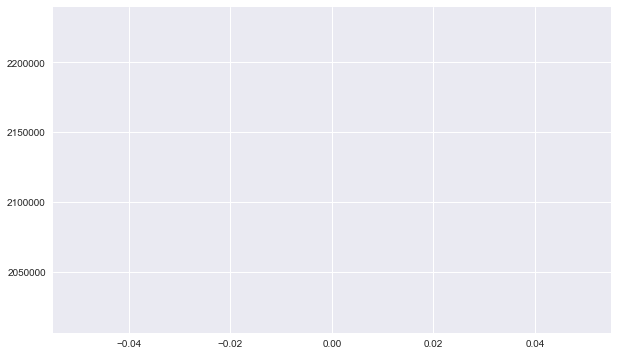

In [12]:
plt.figure(figsize=(10,6))
plt.plot(surplus_arr);

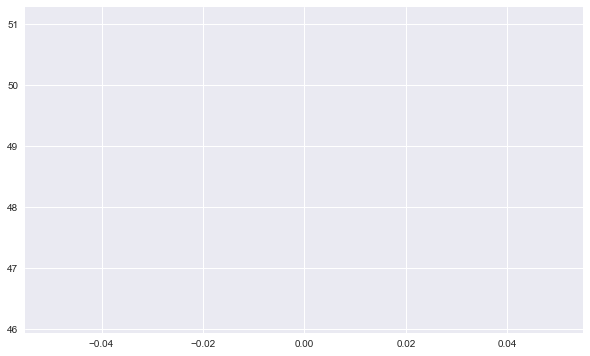

In [13]:
plt.figure(figsize=(10,6))
plt.plot(exe_time_arr);

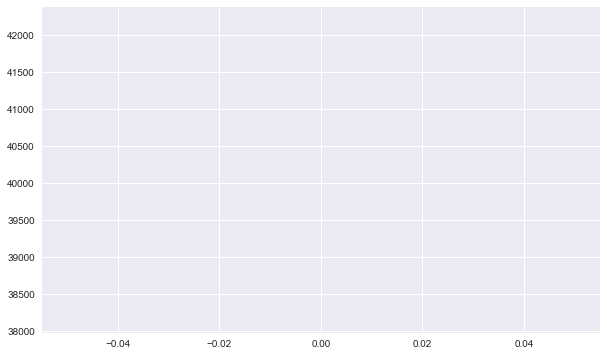

In [14]:
plt.figure(figsize=(10,6))
plt.plot(spread_arr);

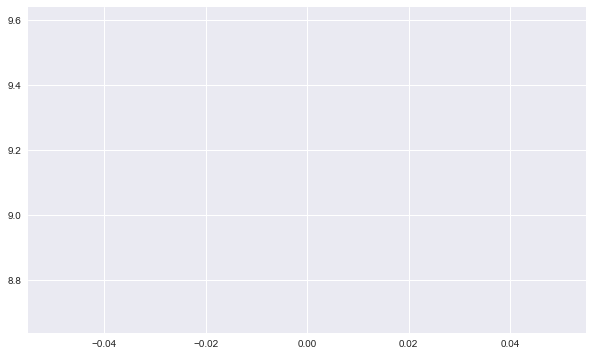

In [15]:
plt.figure(figsize=(10,6))
plt.plot(vola_arr);

In [19]:
Ask_t_t = [x[0] for x in Ask_t]
Ask_t_p = [x[1] for x in Ask_t]
Bid_t_t = [x[0] for x in Bid_t]
Bid_t_p = [x[1] for x in Bid_t]

(0, 2000)

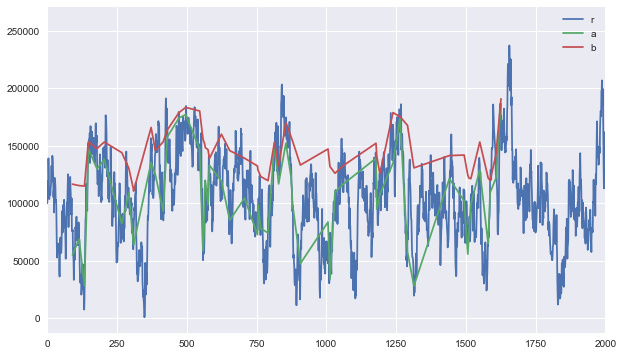

In [21]:
plt.figure(figsize=(10,6))
plt.plot(r,label="r")
plt.plot(Ask_t_t,Ask_t_p,label="a")
plt.plot(Bid_t_t,Bid_t_p,label="b")
plt.legend()
plt.xlim(0,2000)

In [17]:
surplus_arr

[2123211.4127675593]

In [18]:
exe_time_arr

[48.60526315789474]